# Stacked 3D analysis VS reflected regions analysis: a comparison using HESS data 

This notebook closely follows https://docs.gammapy.org/0.13/notebooks/hess.html

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from scipy.stats import norm
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion
from gammapy.data import DataStore
from gammapy.maps import Map, MapAxis, WcsGeom, WcsNDMap
from gammapy.cube import MapMaker, MapMakerObs, MapDataset, PSFKernel, MapMakerRing
from gammapy.cube.models import SkyModel, BackgroundModel
from gammapy.spectrum.models import PowerLaw
from gammapy.spectrum import create_crab_spectral_model
from gammapy.image.models import SkyPointSource, SkyGaussian
from gammapy.detect import compute_lima_on_off_image
from gammapy.scripts import SpectrumAnalysisIACT
from gammapy.utils.fitting import Fit
from gammapy.background import RingBackgroundEstimator
from gammapy.spectrum import FluxPointsEstimator

In [3]:
# pos_crab = SkyCoord.from_name('Crab')
pos_crab = SkyCoord(83.633, 22.014, unit="deg")

In [4]:
data_store = DataStore.from_dir('/home/luca/HESSJ1702-420/HESS/DATA/hap_fr/HESS_newbkg/')
data_store.info()
sep = pos_crab.separation(data_store.obs_table.pointing_radec) # separation between the run pointing position and the Crab nebula
selection_radius = 2*u.deg 
src_runs = (data_store.obs_table[sep < selection_radius])
myid = src_runs['OBS_ID'].data

observations = data_store.get_observations(myid)

Data store:
HDU index table:
BASE_DIR: /home/luca/HESSJ1702-420/HESS/DATA/hap_fr/HESS_newbkg
Rows: 81768
OBS_ID: 18416 -- 122466
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_2d', 'edisp_2d', 'events', 'gti', 'psf_table']

Observation table:
Observatory name: 'N/A'
Number of observations: 13628


In [5]:
len(observations)

167

In the map geom, we choose an energy threshold of 1 TeV:

In [6]:
energy_axis = MapAxis.from_edges(
    np.logspace(0, 1.0, 5), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(83.633, 22.014),
    binsz=0.02,
    width=(5, 5),
    coordsys="CEL",
    proj="TAN",
    axes=[energy_axis],
)

## Standard IACT spectral analysis: Reflected regions  

As a reference, we derive a spectrum for the Crab nebula using a standard and well tested IACT analysis method

In [46]:
on_region = CircleSkyRegion(pos_crab, 0.11 * u.deg)
exclusion_mask = Map.from_geom(geom.to_image())
exclusion_mask.data = np.ones_like(exclusion_mask.data, dtype=bool)

model_pwl = PowerLaw(
    index=2.6, amplitude="5e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)

config = {
    "outdir": ".",
    "background": {"on_region": on_region, "exclusion_mask": exclusion_mask},
    "extraction": {"containment_correction": True},
    "fit": {"model": model_pwl, "fit_range": [1, 10] * u.TeV},
    "fp_binning": np.logspace(0, 1, 11) * u.TeV,
}
analysis = SpectrumAnalysisIACT(observations=observations, config=config)
analysis.run()

/home/luca/gammapy-developement/gammapy/gammapy/spectrum/extract.py:232: RuntimeWarning: invalid value encountered in true_divide
  self.containment = new_aeff.data.data.value / self._aeff.data.data.value


In [47]:
print(model_pwl)

PowerLaw

Parameters: 

	   name     value     error        unit      min max frozen
	--------- --------- --------- -------------- --- --- ------
	    index 2.564e+00 1.740e-02                nan nan  False
	amplitude 4.439e-11 5.785e-13 cm-2 s-1 TeV-1 nan nan  False
	reference 1.000e+00 0.000e+00            TeV nan nan   True

Covariance: 

	   name     index   amplitude reference
	--------- --------- --------- ---------
	    index 3.027e-04 6.649e-15 0.000e+00
	amplitude 6.649e-15 3.346e-25 0.000e+00
	reference 0.000e+00 0.000e+00 0.000e+00


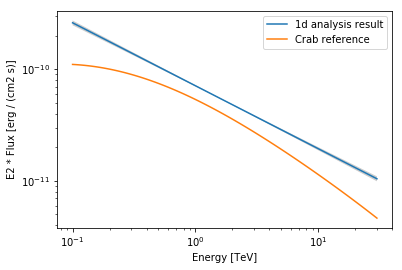

In [48]:
plot_kwargs = {
    "energy_range": [0.1, 30] * u.TeV,
    "energy_power": 2,
    "flux_unit": "erg-1 cm-2 s-1",
}

model_pwl.plot(**plot_kwargs, label="1d analysis result")
model_pwl.plot_error(**plot_kwargs)

create_crab_spectral_model("meyer").plot(**plot_kwargs, label="Crab reference")
plt.legend()

## Stacked 3D analysis (Without edisp)

In [9]:
maker = MapMaker(geom, offset_max="2 deg")
maps = maker.run(observations)
images = maker.run_images()

In [10]:
maps.keys()

dict_keys(['counts', 'exposure', 'background'])

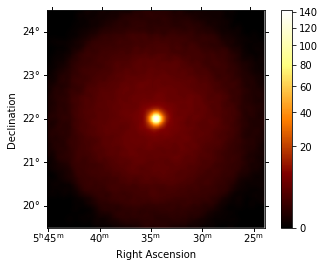

In [11]:
fig, ax, _ = images["counts"].smooth(3).plot(stretch="sqrt", add_cbar=True);

In [59]:
from gammapy.irf import make_mean_psf

table_psf = make_mean_psf(observations, pos_crab)
psf_kernel = PSFKernel.from_table_psf(table_psf, geom, max_radius="1 deg")

In [70]:
spatial_model = SkyPointSource(
    lon_0="83.6 deg", lat_0="22.0 deg", frame="icrs"
)
spectral_model = PowerLaw(
    index=2.57, amplitude="2e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model, name="Crab_nebula")
background_model = BackgroundModel(maps["background"], norm=3, tilt=0.0)
background_model.parameters["norm"].frozen = True
background_model.parameters["tilt"].frozen = True

model.spectral_model.amplitude.frozen = False
model.spectral_model.index.frozen = False

model.spatial_model.lat_0.min = model.spatial_model.lat_0.value-0.15
model.spatial_model.lat_0.max = model.spatial_model.lat_0.value+0.15
model.spatial_model.lon_0.min = model.spatial_model.lon_0.value-0.15
model.spatial_model.lon_0.max = model.spatial_model.lon_0.value+0.15

In [71]:
from gammapy.irf import EnergyDispersion

e_true = geom.axes[0].edges
edisp_diagonal = EnergyDispersion.from_diagonal_response(e_true)

In [72]:
dataset = MapDataset(
    model=model,
    counts=maps["counts"],
    exposure=maps["exposure"],
    background_model=background_model,
    psf=psf_kernel,
    edisp=edisp_diagonal,
)
fit = Fit(dataset)
result = fit.run(optimize_opts={"print_level": 1})
print(result)

FCN = 379721.0498184756 
 TOTAL NCALL = 152 
 NCALLS = 152 
 
 
 EDM = 8.100610386482255e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,par_000_lon_0,8.36295,5.89957e-05,,,8.345,8.375,No
1,par_001_lat_0,2.2022,5.29001e-05,,,2.185,2.215,No
2,par_002_index,2.5264,0.0178609,,,,,No
3,par_003_amplitude,4.36457,0.0751593,,,,,No


OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 152
	total stat : 379721.05



In [73]:
result.parameters.to_table()

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
lon_0,8.363e+01,5.900e-04,deg,8.345e+01,8.375e+01,False
lat_0,2.202e+01,5.290e-04,deg,2.185e+01,2.215e+01,False
index,2.526e+00,1.786e-02,,nan,nan,False
amplitude,4.365e-11,7.516e-13,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
norm,3.000e+00,0.000e+00,,0.000e+00,nan,True
tilt,0.000e+00,0.000e+00,,nan,nan,True
reference,1.000e+00,0.000e+00,TeV,nan,nan,True


In [74]:
result.parameters.covariance_to_table()

name,lon_0,lat_0,index,amplitude,reference,norm,tilt
str9,float64,float64,float64,float64,float64,float64,float64
lon_0,3.481e-07,-2.292e-09,-4.555e-08,2.716e-18,0.000e+00,0.000e+00,0.000e+00
lat_0,-2.292e-09,2.798e-07,6.690e-08,-4.321e-19,0.000e+00,0.000e+00,0.000e+00
index,-4.555e-08,6.690e-08,3.190e-04,1.089e-14,0.000e+00,0.000e+00,0.000e+00
amplitude,2.716e-18,-4.321e-19,1.089e-14,5.649e-25,0.000e+00,0.000e+00,0.000e+00
reference,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00
norm,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00
tilt,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00
reference,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00


(<matplotlib.axes._subplots.WCSAxesSubplot at 0x7faa4951f278>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faa494a9ba8>)

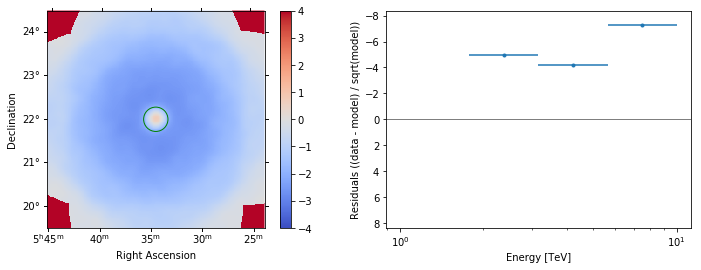

In [87]:
on_region = CircleSkyRegion(pos_crab, 0.28*u.deg)
dataset.plot_residuals(region=on_region, method='diff/sqrt(model)', vmin=-4, vmax=4)

In [88]:
e_edges = np.logspace(0, 1, 11) * u.TeV
fpe = FluxPointsEstimator(
    datasets=[dataset], e_edges=e_edges, source="Crab_nebula"
)
flux_points = fpe.run()

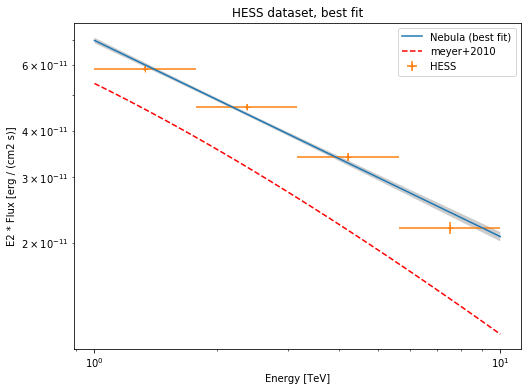

In [89]:
fig, ax = plt.subplots(figsize=(8, 6))

opts = {
    "energy_range": [1 * u.TeV, 10 * u.TeV],
    "energy_power": 2,
    "flux_unit": "erg-1 cm-2 s-1",
}

model.spectral_model.plot(label='Nebula (best fit)', **opts);

covariance = result.parameters.covariance
model.spectral_model.parameters.covariance = covariance[2:5, 2:5]
model.spectral_model.plot_error(**opts)

flux_points.plot(energy_power=2, label='HESS', flux_unit="erg-1 cm-2 s-1")

# Show Meyer et al. (2010) Crab spectrum as reference
model_hess = create_crab_spectral_model("meyer")
model_hess.plot(label="meyer+2010", color="red", ax=ax, **opts, linestyle='--')

#plt.ylim(1e-11, 2e-10)
plt.title('HESS dataset, best fit')
plt.legend();

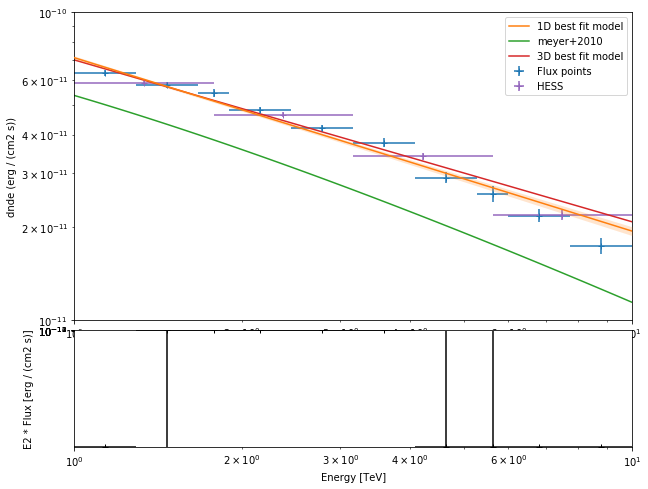

In [92]:
plt.figure(figsize=(10, 8))
crab_ref = create_crab_spectral_model("meyer")

dataset_fp = analysis.spectrum_result

plot_kwargs = {
    "energy_range": [1, 10] * u.TeV,
    "flux_unit": "erg-1 cm-2 s-1",
    "energy_power": 2,
}

model_kwargs = {"label": "1D best fit model"}
model_kwargs.update(plot_kwargs)
ax_spectrum, ax_residuals = dataset_fp.peek(model_kwargs=model_kwargs)

crab_ref.plot(ax=ax_spectrum, label="meyer+2010", **plot_kwargs)
model.spectral_model.plot(
    ax=ax_spectrum, label="3D best fit model", **plot_kwargs
)
model.spectral_model.plot_error(**plot_kwargs)
flux_points.plot(ax=ax_spectrum, energy_power=2, label='HESS', flux_unit="erg-1 cm-2 s-1")

ax_spectrum.set_ylim(1e-11, 1e-10)
ax_spectrum.legend();

In [58]:
from pathlib import Path

path = Path("analysis_3d")
path.mkdir(exist_ok=True)

# write maps
maps["counts"].write(str(path / "counts.fits"), overwrite=True)
maps["background"].write(str(path / "background.fits"), overwrite=True)
maps["exposure"].write(str(path / "exposure.fits"), overwrite=True)

# write IRFs
psf_kernel.write(str(path / "psf.fits"), overwrite=True)
edisp_diagonal.write(str(path / "edisp.fits"), overwrite=True)

When I fix the background norm and tilt (to the best fit values of https://docs.gammapy.org/0.13/notebooks/hess.html), I get a nice spectral fit (matching the 1d result) but a bad spatial result. The opposit happens if I don't fix the background norm.